# 멀티캠퍼스 프로젝트 AI 서비스 개발 과정 프로젝트(핫딜노마드)
## Shopee - Price Match Guarantee
## image part
### image
[Shopee - Price Match Guarantee](https://www.kaggle.com/c/shopee-product-matching/)
> EDA에서 도출된 이미지 데이터의 정보들을 통해 방향 설정
### 도출된 이미지 데이터 정보
- 같은 제품의 이미지라도 위치, 방향 등이 다름
- phash의 차이가 5 이하의 다른 제품의 이미지
- 결론
    1. 객체 검출을 통해 사물을 특징을 뽑을 필요가 있음
    2. 
### Object Detection(객체 검출)

Object Detection이란 입력 영상이 주어질 때, 영상 내 존재하는 모든 카테고리에 대해서 

classification과 localization을 수행하는 task



- Image_phash Data AI Model
- Hash method
    - average hashing (aHash)
    - **perception hashing (pHash)**
        - 밝기 값으로 이미지 구조를 분석, 그 값에 따라 T, F 부여
        - Divide the image into a matrix with a Bool value Match the phash value of the two images to compare as the difference approaches zero
    - difference hashing (dHash)
    - wavelet hashing (wHash)

In [1]:
!pip install imagehash
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 296kB 17.2MB/s 
     |████████████████████████████████| 55.7MB 54kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
# 파일 처리
import os, sys

# Data 처리
import string
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

# 이미지 및 그래프 출력
import imagehash
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# 경고메시지 지우기
import warnings
warnings.filterwarnings(action='ignore')

# 상태바 상태
from tqdm import tqdm


In [3]:
# Raw Data
base_dir = '/content/drive/MyDrive/Colab/Data/shopee-product-matching'
base_dir_list = sorted(os.listdir(base_dir))
base_dir_list


['sample_submission.csv',
 'test.csv',
 'test_images',
 'train.csv',
 'train_images']

In [4]:
submission = pd.read_csv(os.path.join(base_dir, base_dir_list[0]))
train = pd.read_csv(os.path.join(base_dir, base_dir_list[3]))
test = pd.read_csv(os.path.join(base_dir, base_dir_list[1]))
train_img = os.path.join(base_dir, base_dir_list[-1])
train['image'] = train_img +'/' + train['image']
test_img = os.path.join(base_dir, base_dir_list[2])


In [5]:
train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,/content/drive/MyDrive/Colab/Data/shopee-produ...,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,/content/drive/MyDrive/Colab/Data/shopee-produ...,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,/content/drive/MyDrive/Colab/Data/shopee-produ...,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,/content/drive/MyDrive/Colab/Data/shopee-produ...,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,/content/drive/MyDrive/Colab/Data/shopee-produ...,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [6]:
test.head()

,posting_id,image,image_phash,title
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


### SIFT(Scale-invariant Feature Transform)

- 이미지의 크기와 회전에 불변하는 특징을 추출하는 알고리즘
- 서로 다른 두 이미지에서 SIFT 특징을 각각 추출한 다음에 비슷한 특징끼리 매칭해주면 두 이미지에서 대응되는 부분을 찾을 수 있다

### SIFT의 순서

1. Scale space 생성
2. DoG(Difference of Gaussian) 연산
3. keypoint 찾기
4. 나쁜 keypoint 제거
5. keypoint들에 방향 할당
6. SIFT 특징 산출

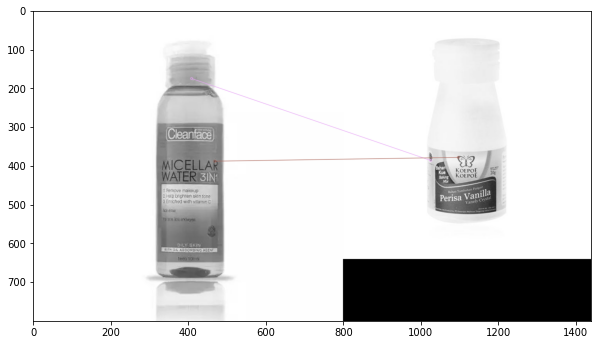

2


In [9]:
img1 = cv2.imread(train['image'].iloc[1171], 0)          # queryImage
img2 = cv2.imread(train['image'].iloc[2022], 0)          # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create(300) # 최대로 찾을 특징점의 수

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append([m])

        # cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 7))
plt.imshow(img3),plt.show()
print(len(good)) # 찾은 특징점 수   

위의 결과로 pHash 값의 차이가 5 이하인 제품들을 효과적으로 구분할 수 있다.

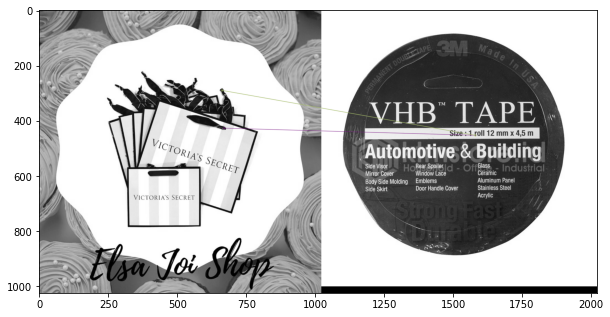

3


In [10]:
img1 = cv2.imread(train['image'].iloc[0], 0)          # queryImage
img2 = cv2.imread(train['image'].iloc[1], 0)          # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create(300) # 최대로 찾을 특징점의 수

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append([m])

        # cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 7))
plt.imshow(img3),plt.show()
print(len(good))

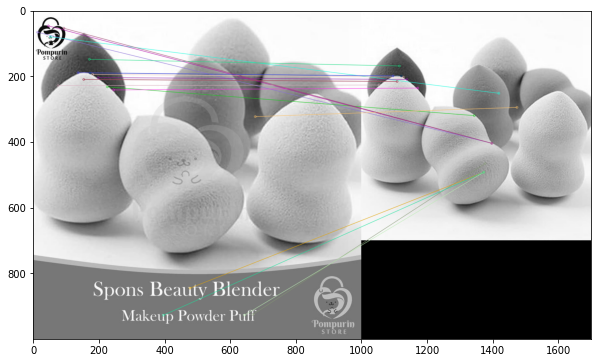

19


In [11]:
img1 = cv2.imread(train['image'].iloc[33769], 0)          # queryImage
img2 = cv2.imread(train['image'].iloc[849], 0)          # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create(500) # 최대로 찾을 특징점의 수

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append([m])

        # cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 7))
plt.imshow(img3),plt.show()
print(len(good))

In [12]:
# a function for sift distance
def sift_match(path1, path2):
    img1 = cv2.imread(path1, 0)
    img2 = cv2.imread(path2, 0)
    # Initiate SIFT detector
    sift = cv2.SIFT_create(300)
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append([m])

    return len(good)

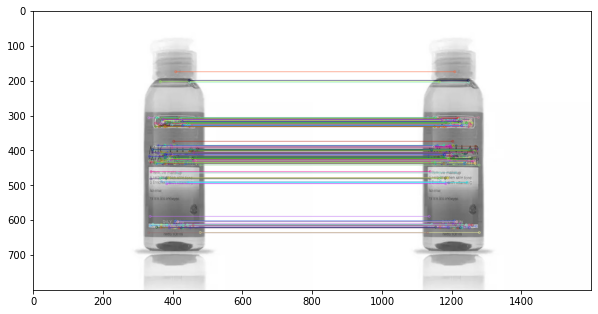

300

In [13]:
sift_match(train['image'][1171], train['image'][1171])